In [2]:
import os
import librosa
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from python_speech_features import mfcc
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout
from keras.models import Sequential

In [4]:
df = pd.read_csv('train.csv')
df.head()

,fname,label,manually_verified
0,00044347.wav,Hi-hat,0
1,001ca53d.wav,Saxophone,1
2,002d256b.wav,Trumpet,0
3,0033e230.wav,Glockenspiel,1
4,00353774.wav,Cello,1


In [5]:
df = df[df['label'].isin(['Cello','Saxophone','Acoustic_guitar','Double_bass', 'Clarinet'])]

In [6]:
path = 'Downloads/audio_train/'
audio_data = list()
for i in tqdm(range(df.shape[0])):
    audio_data.append(librosa.load(path+df['fname'].iloc[i]))
audio_data = np.array(audio_data)

100%|██████████████████████████████████████████████████████████████████████████████| 1500/1500 [09:18<00:00,  2.69it/s]
<ipython-input-6-57b4781a9981>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  audio_data = np.array(audio_data)


In [7]:
df['audio_waves'] = audio_data[:,0]
df['samplerate'] = audio_data[:,1]
df.head()

,fname,label,manually_verified,audio_waves,samplerate
1,001ca53d.wav,Saxophone,1,"[-0.0007303721, -0.0010996412, -0.0010551845, ...",22050
4,00353774.wav,Cello,1,"[-0.003822653, -0.0053708917, -0.0044372473, -...",22050
5,003b91e8.wav,Cello,0,"[0.0031921505, 0.0048865937, 0.004513402, 0.00...",22050
8,004ad66f.wav,Clarinet,0,"[-0.00018609133, -0.00029739283, -0.0003075322...",22050
14,0091fc7f.wav,Cello,1,"[0.00042805163, 0.0005860274, 0.00045838652, 0...",22050


In [8]:
bit_lengths = list()
for i in range(df.shape[0]):
    bit_lengths.append(len(df['audio_waves'].iloc[i]))
bit_lengths = np.array(bit_lengths)
df['bit_lengths'] = bit_lengths
df['seconds_length'] = df['bit_lengths']/df['samplerate']
df.head()

,fname,label,manually_verified,audio_waves,samplerate,bit_lengths,seconds_length
1,001ca53d.wav,Saxophone,1,"[-0.0007303721, -0.0010996412, -0.0010551845, ...",22050,227556,10.32
4,00353774.wav,Cello,1,"[-0.003822653, -0.0053708917, -0.0044372473, -...",22050,99666,4.52
5,003b91e8.wav,Cello,0,"[0.0031921505, 0.0048865937, 0.004513402, 0.00...",22050,292824,13.28
8,004ad66f.wav,Clarinet,0,"[-0.00018609133, -0.00029739283, -0.0003075322...",22050,154350,7
14,0091fc7f.wav,Cello,1,"[0.00042805163, 0.0005860274, 0.00045838652, 0...",22050,125685,5.7


In [9]:
df = df[df['seconds_length'] >= 2.0]

In [10]:
min_bits = np.min(df['bit_lengths'])
print(min_bits)
min_seconds = np.min(df['seconds_length'])
print(min_seconds)

44100
2.0


In [11]:
with open('audio_df.pickle', 'wb') as f:
    pickle.dump(df, f)

In [12]:
with open('audio_df.pickle', 'rb') as f:
    df = pickle.load(f)

In [13]:
num_samples = 6000
generated_audio_waves = list()
generated_audio_labels = list()
for i in tqdm(range(num_samples)):
    try:
        chosen_file = np.random.choice(df['fname'].values)
        chosen_initial = np.random.choice(np.arange(0,df[df['fname']==chosen_file]['bit_lengths'].values-min_bits))
        generated_audio_waves.append(df[df['fname']==chosen_file]['audio_waves'].values[0][chosen_initial:chosen_initial+min_bits])
        
        generated_audio_labels.append(df[df['fname']==chosen_file]['label'].values)
    except ValueError:
        continue
generated_audio_waves = np.array(generated_audio_waves)
generated_audio_labels = np.array(generated_audio_labels)

100%|█████████████████████████████████████████████████████████████████████████████| 6000/6000 [00:21<00:00, 281.18it/s]


In [14]:
mfcc_features = list()
for i in tqdm(range(len(generated_audio_waves))):
    mfcc_features.append(mfcc(generated_audio_waves[i]))
mfcc_features = np.array(mfcc_features)

100%|█████████████████████████████████████████████████████████████████████████████| 5968/5968 [00:44<00:00, 132.82it/s]


In [15]:
print(generated_audio_waves.shape)
print(mfcc_features.shape)

(5968, 44100)
(5968, 275, 13)


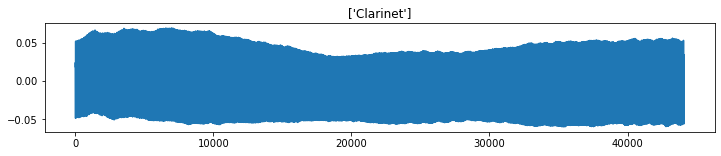

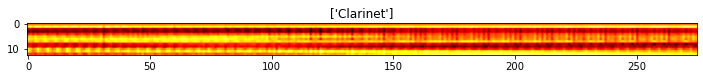

In [16]:
plt.figure(figsize=(12,2))
plt.plot(generated_audio_waves[30])
plt.title(generated_audio_labels[30])
plt.show()
plt.figure(figsize=(12, 2))
plt.imshow(mfcc_features[30].T, cmap='hot')
plt.title(generated_audio_labels[30])
plt.show()

In [17]:
label_encoder = LabelEncoder()
label_encoded = label_encoder.fit_transform(generated_audio_labels)
print(label_encoded)

C:\Users\HP\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[0 4 1 ... 3 0 4]


In [18]:
label_encoded = label_encoded[:, np.newaxis]
label_encoded

array([[0],
       [4],
       [1],
       ...,
       [3],
       [0],
       [4]])

In [19]:
one_hot_encoder = OneHotEncoder(sparse=False)
one_hot_encoded = one_hot_encoder.fit_transform(label_encoded)
one_hot_encoded

array([[1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.]])

In [20]:
X = mfcc_features
y = one_hot_encoded
X = (X-X.min())/(X.max()-X.min())
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [21]:
input_shape = (X_train.shape[1], X_train.shape[2], 1)

In [22]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
print(X_train.shape)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)
print(X_test.shape)

(4774, 275, 13, 1)
(1194, 275, 13, 1)


In [23]:
model = Sequential()
model.add(Conv2D(16, (3, 3), activation='relu', strides=(1, 1), 
    padding='same', input_shape=input_shape))
model.add(Conv2D(32, (3, 3), activation='relu', strides=(1, 1), 
    padding='same'))
model.add(MaxPool2D((2, 2)))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax'))

model.compile(loss='categorical_crossentropy', 
     optimizer='adam',
     metrics=['acc'])

In [24]:
history = model.fit(X_train, y_train, epochs=30, validation_data=(X_test, y_test))

Epoch 1/30
150/150 [==============================] - 46s 226ms/step - loss: 1.6217 - acc: 0.2566 - val_loss: 1.2192 - val_acc: 0.4414
Epoch 2/30
150/150 [==============================] - 31s 208ms/step - loss: 1.2543 - acc: 0.4338 - val_loss: 1.0253 - val_acc: 0.5343
Epoch 3/30
150/150 [==============================] - 31s 206ms/step - loss: 1.1396 - acc: 0.5144 - val_loss: 0.9324 - val_acc: 0.6625
Epoch 4/30
150/150 [==============================] - 30s 203ms/step - loss: 1.0149 - acc: 0.5947 - val_loss: 0.9284 - val_acc: 0.6139
Epoch 5/30
150/150 [==============================] - 30s 200ms/step - loss: 0.9649 - acc: 0.6276 - val_loss: 0.7262 - val_acc: 0.7521
Epoch 6/30
150/150 [==============================] - 33s 218ms/step - loss: 0.8701 - acc: 0.6641 - val_loss: 0.6573 - val_acc: 0.7730
Epoch 7/30
150/150 [==============================] - 29s 193ms/step - loss: 0.7928 - acc: 0.7160 - val_loss: 0.6074 - val_acc: 0.7956
Epoch 8/30
150/150 [==============================] - 3

loss: 0.42330402135849
val_loss: 0.42003512382507324


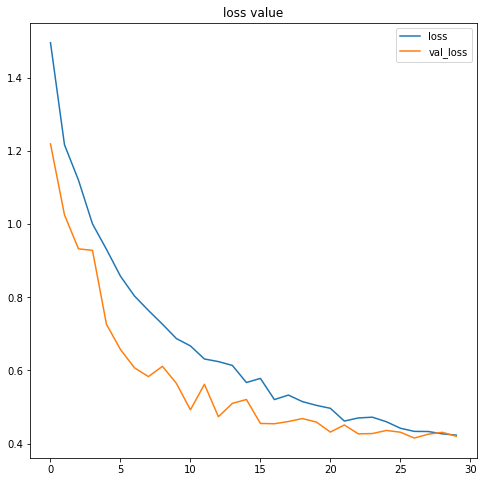

acc: 0.8498114943504333
val_acc: 0.8676716685295105


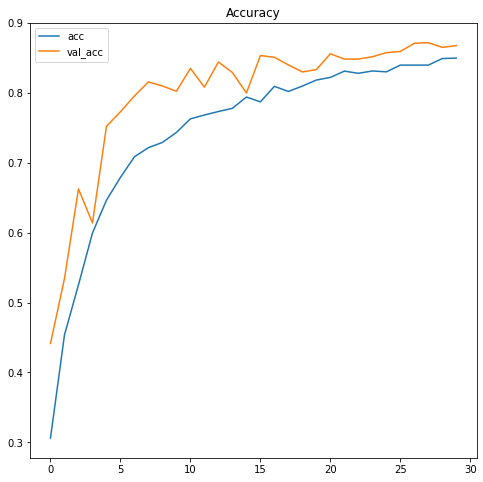

In [25]:
plt.figure(figsize=(8,8))
plt.title('loss value')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss', 'val_loss'])
print('loss:', history.history['loss'][-1])
print('val_loss:', history.history['val_loss'][-1])
plt.show()
plt.figure(figsize=(8,8))
plt.title('Accuracy')
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.legend(['acc', 'val_acc'])
print('acc:', history.history['acc'][-1])
print('val_acc:', history.history['val_acc'][-1])
plt.show()

In [26]:
model1 = Sequential()
model1.add(Conv2D(16, (3, 3), activation='relu', strides=(1, 1), 
    padding='same', input_shape=input_shape))
model1.add(Conv2D(32, (3, 3), activation='relu', strides=(1, 1), 
    padding='same'))
model1.add(MaxPool2D((2, 2)))
model1.add(Dropout(0.5))
model1.add(Flatten())
model1.add(Dense(128, activation='relu'))
model1.add(Dropout(0.5))
model1.add(Dense(64, activation='relu'))
model1.add(Dropout(0.5))
model1.add(Dense(5, activation='softmax'))

model1.compile(loss='categorical_crossentropy', 
     optimizer='RMSprop',
     metrics=['acc'])

In [27]:
history = model1.fit(X_train, y_train, epochs=30, validation_data=(X_test, y_test))

Epoch 1/30
150/150 [==============================] - 42s 242ms/step - loss: 1.6327 - acc: 0.2711 - val_loss: 1.2132 - val_acc: 0.5025
Epoch 2/30
150/150 [==============================] - 35s 235ms/step - loss: 1.2506 - acc: 0.4561 - val_loss: 1.0050 - val_acc: 0.5838
Epoch 3/30
150/150 [==============================] - 40s 265ms/step - loss: 1.1090 - acc: 0.5530 - val_loss: 1.0907 - val_acc: 0.6030
Epoch 4/30
150/150 [==============================] - 36s 240ms/step - loss: 0.9851 - acc: 0.6125 - val_loss: 0.8961 - val_acc: 0.6415
Epoch 5/30
150/150 [==============================] - 38s 257ms/step - loss: 0.9281 - acc: 0.6473 - val_loss: 0.7549 - val_acc: 0.7178
Epoch 6/30
150/150 [==============================] - 35s 236ms/step - loss: 0.8384 - acc: 0.6875 - val_loss: 0.9762 - val_acc: 0.6281
Epoch 7/30
150/150 [==============================] - 37s 245ms/step - loss: 0.8112 - acc: 0.7029 - val_loss: 0.6255 - val_acc: 0.7789
Epoch 8/30
150/150 [==============================] - 3

loss: 0.5462588667869568
val_loss: 0.48214587569236755


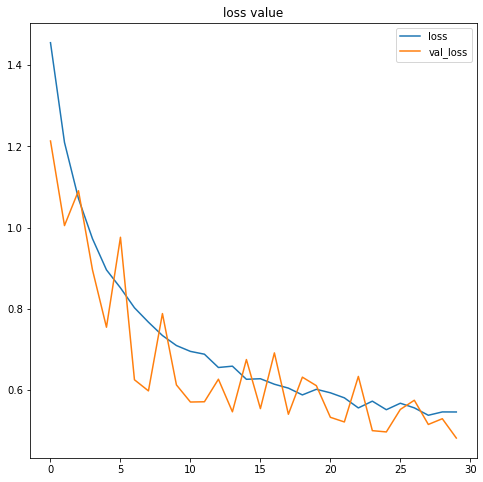

acc: 0.8089652061462402
val_acc: 0.8350083827972412


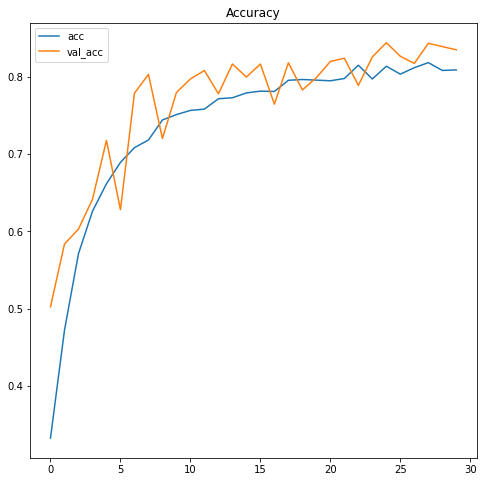

In [28]:
plt.figure(figsize=(8,8))
plt.title('loss value')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss', 'val_loss'])
print('loss:', history.history['loss'][-1])
print('val_loss:', history.history['val_loss'][-1])
plt.show()
plt.figure(figsize=(8,8))
plt.title('Accuracy')
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.legend(['acc', 'val_acc'])
print('acc:', history.history['acc'][-1])
print('val_acc:', history.history['val_acc'][-1])
plt.show()

In [29]:
model2 = Sequential()
model2.add(Conv2D(16, (3, 3), activation='relu', strides=(1, 1), 
    padding='same', input_shape=input_shape))
model2.add(Conv2D(32, (3, 3), activation='relu', strides=(1, 1), 
    padding='same'))
model2.add(MaxPool2D((2, 2)))
model2.add(Dropout(0.5))
model2.add(Flatten())
model2.add(Dense(128, activation='relu'))
model2.add(Dropout(0.5))
model2.add(Dense(64, activation='relu'))
model2.add(Dropout(0.5))
model2.add(Dense(5, activation='softmax'))

model2.compile(loss='categorical_crossentropy', 
     optimizer='SGD',
     metrics=['acc'])

In [30]:
history = model2.fit(X_train, y_train, epochs=30, validation_data=(X_test, y_test))

Epoch 1/30
150/150 [==============================] - 38s 211ms/step - loss: 1.6202 - acc: 0.2045 - val_loss: 1.5988 - val_acc: 0.2152
Epoch 2/30
150/150 [==============================] - 32s 214ms/step - loss: 1.6012 - acc: 0.2458 - val_loss: 1.5498 - val_acc: 0.3191
Epoch 3/30
150/150 [==============================] - 30s 197ms/step - loss: 1.5367 - acc: 0.3130 - val_loss: 1.3871 - val_acc: 0.4497
Epoch 4/30
150/150 [==============================] - 30s 201ms/step - loss: 1.4257 - acc: 0.3759 - val_loss: 1.2792 - val_acc: 0.4322
Epoch 5/30
150/150 [==============================] - 29s 196ms/step - loss: 1.3451 - acc: 0.4042 - val_loss: 1.3264 - val_acc: 0.3894
Epoch 6/30
150/150 [==============================] - 30s 200ms/step - loss: 1.2592 - acc: 0.4493 - val_loss: 1.1584 - val_acc: 0.5360
Epoch 7/30
150/150 [==============================] - 34s 225ms/step - loss: 1.2275 - acc: 0.4805 - val_loss: 1.2267 - val_acc: 0.4916
Epoch 8/30
150/150 [==============================] - 3

loss: 0.640847384929657
val_loss: 0.5096685886383057


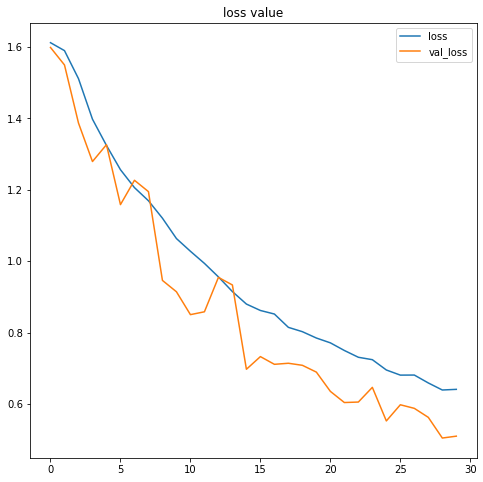

acc: 0.764976978302002
val_acc: 0.839195966720581


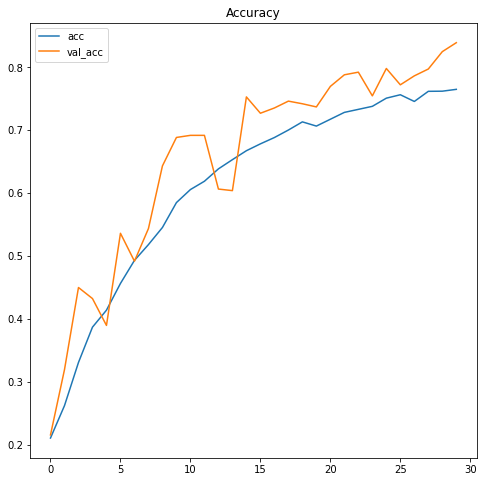

In [31]:
plt.figure(figsize=(8,8))
plt.title('loss value')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss', 'val_loss'])
print('loss:', history.history['loss'][-1])
print('val_loss:', history.history['val_loss'][-1])
plt.show()
plt.figure(figsize=(8,8))
plt.title('Accuracy')
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.legend(['acc', 'val_acc'])
print('acc:', history.history['acc'][-1])
print('val_acc:', history.history['val_acc'][-1])
plt.show()

In [33]:
model = Sequential()
model.add(Conv2D(16, (3, 3), activation='relu', strides=(1, 1), 
    padding='same', input_shape=input_shape))
model.add(Conv2D(32, (3, 3), activation='relu', strides=(1, 1), 
    padding='same'))
model.add(MaxPool2D((2, 2)))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax'))

model.compile(loss='tf.keras.losses.KLDivergence()', 
     optimizer='SGD',
     metrics=['acc'])

loss: 0.2682487964630127
val_loss: 0.4521157443523407


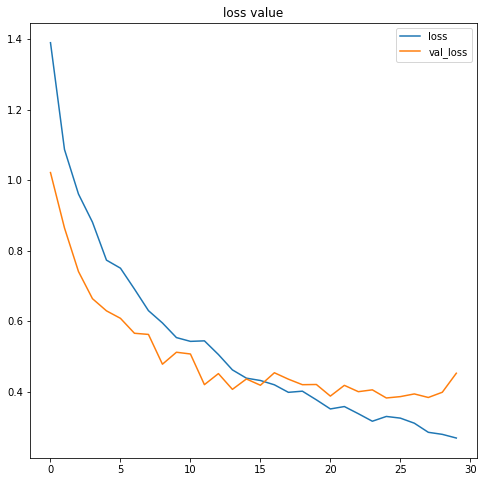

acc: 0.9047519564628601
val_acc: 0.8786610960960388


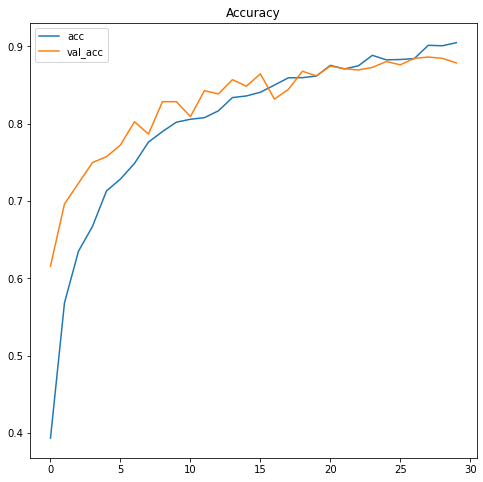

In [34]:
plt.figure(figsize=(8,8))
plt.title('loss value')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss', 'val_loss'])
print('loss:', history.history['loss'][-1])
print('val_loss:', history.history['val_loss'][-1])
plt.show()
plt.figure(figsize=(8,8))
plt.title('Accuracy')
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.legend(['acc', 'val_acc'])
print('acc:', history.history['acc'][-1])
print('val_acc:', history.history['val_acc'][-1])
plt.show()

In [32]:
predictions = model.predict(X_test)

In [33]:
predictions = np.argmax(predictions, axis=1)
y_test = one_hot_encoder.inverse_transform(y_test)

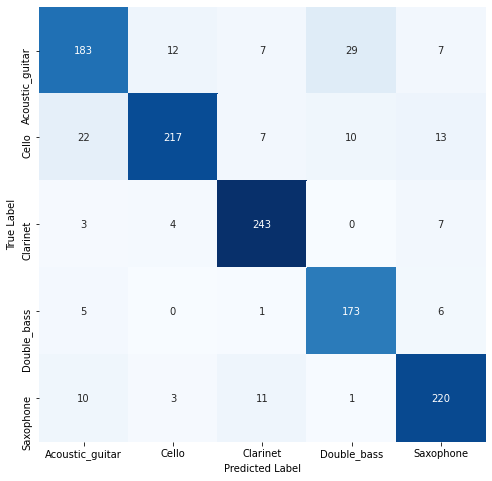

In [34]:
cm = confusion_matrix(y_test, predictions)
plt.figure(figsize=(8,8))
sns.heatmap(cm, annot=True, xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_, fmt='d', cmap=plt.cm.Blues, cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()